In [1]:
# Importação dos módulos
import random, string
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output

## Questão 1

### Implementação
Para este problema, fez-se testes utilizando alguns metodos de Seleção dos Pais(n Melhores, Proporcional + roleta), Crossover (Uniforme, Single-Point), seleção de sobreviventes (Geracional e elitista), com apenas um teste de metodo de mutação (Mutação Uniforme) e após sucessivas tentativas, os métodos que obtiveram os melhores resultados foram:  
1. Mecanismo de Seleção dos Pais:
    -  Operador de Seleção Proporcional ao Fitness + Roleta;
2. Operador de Cruzamento
    - Crossover Uniforme
3. Operador de Mutação
    - Mutação Uniforme
4. Mecanismo de Seleção dos Sobreviventes
    - Substituição baseada em fitness + elitista (para uma população de 100, manteve-se os 25 melhores da geração anterior e descartou-se os 25 piores descendentes)

In [2]:
conjuntoCaracteres_Weasel = "".join(string.ascii_uppercase + " " + string.digits)
fraseObjetivo_Weasel = "METHINKS IT IS LIKE A WEASEL"

class Individuo_Weasel():
    def __init__(self,frase=None):
        if frase == None:
            self.frase = self.GerarFraseAleatoria(conjuntoCaracteres_Weasel,28)
        else:
            self.frase = frase
        self.score = self.getScore(self.frase,fraseObjetivo_Weasel) # Aptidao
       
    def GerarFraseAleatoria(self,conjuntoCaracteres,tamanhoFrase):
        frase = ''.join(self.GerarCaractere(conjuntoCaracteres) for i in range(tamanhoFrase))
        return frase
    
    def GerarCaractere(self,conjunto):
        return random.choice(conjunto)
    
    def getScore(self,fraseGerada,fraseObjetivo):
        self.score = 0
        for i,letra in enumerate(fraseGerada):
            if(fraseObjetivo[i] == letra):
                self.score +=1
        return self.score
    
    def Mutate(self,mutationChance): # Muta cada caractere
        lista = list(self.frase) # Transforma a frase em uma lista
        for i in range(len(lista)):
            randomico = random.random() # Pega um numero aleatorio entre 0 e 1 (float)
            if random.random() <= mutationChance: # Caso ocorra a mutacao
                # remove o caractere atual para nao ocorrer a chance do mesmo ser "sorteado"
                novo_conjunto =  conjuntoCaracteres_Weasel.replace(lista[i],'') 
                lista[i] = self.GerarCaractere(novo_conjunto) 
        self.frase = ''.join(lista)
        self.score = self.getScore(self.frase,fraseObjetivo_Weasel) # Atualiza a pontuacao após mutacao
        return self.frase

In [3]:
class AlgoritmoEvolutivo_Weasel():
    def __init__(self,populacao:int = 20):
        self.population = []
        self.bestPontuacaoList = []
        self.meanPontuacaoList = [] 
        for i in range (populacao):
            self.population.append(Individuo_Weasel())
            
         
    def ParentSelector(self): # Roulette-wheel selection
        probabilidades = [],[]# lista de 2 dimensoes contendo em [0] -> as probabilidades e [1] - > probab acumulada
        aptidaoTotal = sum([individuo.score for individuo in self.population])
        probabAcumulada = 0
        for individuo in self.population:
            probabilidades[0].append(individuo.score/aptidaoTotal)
            probabAcumulada += individuo.score/aptidaoTotal
            probabilidades[1].append(probabAcumulada)
        parents = []
        for i in range(2): # Seleciona 2 pais
            roleta = random.random() # numero de 0 a 1
            for j,probabAcumulada in enumerate(probabilidades[1]):
                if(roleta < probabAcumulada): # se o numero da roleta for menor que o da prob, parar
                    parents.append(self.population[j])                       
                    break
        return parents      
    
    def CrossOver(self,parents,crossOverChance=0.8): # Sera testado o crossover uniforme
        filho1Frase = ""
        filho2Frase = ""
        if random.random() < crossOverChance:
            for i in range(len(parents[0].frase)):
                if random.random() < 0.5:
                    filho1Frase += parents[0].frase[i]
                    filho2Frase += parents[1].frase[i]
                else:
                    filho1Frase += parents[1].frase[i]
                    filho2Frase += parents[0].frase[i]    
        else:
            filho1Frase = parents[0].frase
            filho2Frase = parents[1].frase
        
        filho1 = Individuo_Weasel(filho1Frase)
        filho2 = Individuo_Weasel(filho2Frase)
        return [filho1,filho2]
    
    def OrdenarPopulacao(self): # Ordena populacao entre melhores individuos, sendo o index 0 o melhor individuo
        self.population = sorted(self.population, key=lambda population: population.score,reverse=True)
        
    def SurvivorSelector(self,nPiores): # remove os n piores individuos da geração
        self.OrdenarPopulacao()
        for i in range(nPiores):
            self.population.pop()
            
    def SurvivorSelector_Geracional(self,newPopulation): # substitui a populacao por uma nova
        self.population = newPopulation
    
    def SurvivorSelector_Elitism(self,newPopulation,nSubstitution):
        '''
        Mantem os n melhores individuos da antiga e remove os n piores individuos da atual
        '''
        sortedOldPopulation = sorted(self.population, key=lambda population: population.score,reverse=True)
        sortedNewPopulation = sorted(newPopulation, key=lambda population: population.score,reverse=True)
        for i in range(nSubstitution):
            sortedNewPopulation.pop()  # Remove o pior(Ultimo da lista)
        for i in range(nSubstitution): # Precisa de 2 "fors" para nao remover o recem adicionado
            sortedNewPopulation.append(sortedOldPopulation[i]) # Adiciona os melhores da populacao velha
        self.population = sortedNewPopulation # Define a populacao como a nova, ja removida dos n piores dela mesma e 
                                              # acrescida dos melhores da geração anterior
    
    
    def run(self,maxgen,chanceMutacao=0.05,chanceCrossOver=0.8,nElitismo=4):
        ngen=0
        while ngen < maxgen:
            ngen += 1
            novaPopulacao = []
            # como 2 pais geram 2 filhos, precisa-se fazer n/2 cruzamentos para manter o mesmo numero de individuos
            for i in range(int(len(self.population)/2)): 
                parents = self.ParentSelector()
                filhos = self.CrossOver(parents,crossOverChance=chanceCrossOver)
                for filho in filhos:
                    filho.Mutate(mutationChance=chanceMutacao)
                    novaPopulacao.append(filho) # Adiciona o filho  (depois de muta-lo) a populacao 
            self.SurvivorSelector_Elitism(novaPopulacao,nElitismo)
    
            # Avaliacao do algoritmo
            bestPontuacao = max([individuo.score for individuo in self.population])
            self.bestPontuacaoList.append(bestPontuacao)
            clear_output(wait=True) # Limpa o console, para sobrescrever o print abaixo
            print("Geração Atual:{}/{}         MelhorPontuação:{}".format(ngen+1,maxgen,bestPontuacao))
            print("Melhor Frase:",self.population[0].frase)
            if (bestPontuacao == 28):
                break
        return [ngen,bestPontuacao, self.population[0].frase,self.bestPontuacaoList]

### Questão 1a
**Pergunta:** Assumindo que apenas o caracter de espaço (representado por *), letras maísculas e dígitos são permitidos, calcule a dimensão do espaço de busca para esse problema. Qual a probabilidade de uma string gerada aleatoriamente ser exatamente igual à string alvo?

**R.:** Contando todas as letras, digitos e espaço, têm-se um total de 37 caracteres e, como a frase alvo possui 28 caracteres, a probabilidade da string aleatoria ser exatamente igual a string alvo é de 1 em $37^{28} \approx 8.12  \cdot 10^{43}$.


### Questão 1b
**Pergunta:** Explique como o algoritmo genético consegue superar essa probabilidade
incrivelmente pequena.

**R.:** 
- O algoritmo genético consegue superar essa probabilidade incrivelmente pequena, devido a implementação de uma evolução da frase gerada aleatoriamente. Essa frase possui uma pontuação e pontuações melhores tendem a se perpetuar na população, assim como espécies biológicas. Perpetuando melhores pontuações, elas se mutam/cruzam entre sí, gerando cada vez melhores individuos para o problema, até convergir para o resultado ótimo/ideal, que para este caso é a frase alvo "METHINKS IT IS LIKE A WEASEL".
- Uma observação importante para esse problema foi a implementação do elitismo, sem ele o algoritmo não convergia para a pontuação ótima, e foi necessário sua utilização para manter uma certa quantidade da populacao antiga(os melhores dela), nas gerações seguintes, colaborando para a convergência do algoritmo

### Questão 1c
**Pergunta:** Calcule o número médio de gerações para convergência.

**R.:** Para uma população de 100 individuos, com uma chance de Mutação de 6% e chance de CrossOver de 80%, 50 cruzamentos, e manutenção dos 25 melhores individuos da geração anterior, o número médio de gerações para convergência foi de **81.67**, como pode-se observar abaixo

In [4]:
ngens = []
convergiu = 0
for i in range(100): # Realiza o algoritmo 100 vezes para calcular a media de geracoes para convergencia
    
    algoritmo_weasel = AlgoritmoEvolutivo_Weasel(populacao=100)
    [ngen,bestPontuacao, bestFrase,bestPontuacaoList] = algoritmo_weasel.run(maxgen=500,
                                                                            chanceMutacao=0.05,
                                                                            chanceCrossOver=0.9,
                                                                            nElitismo=25)
    ngens.append(ngen)
    if bestPontuacao == 28: # Convergiu       
        convergiu +=1
print("Convergiram/Geraçoes Concluidas: {}/{}           Média Gerações: {}".format(convergiu,len(ngens),np.mean(ngens)))

Geração Atual:88/500         MelhorPontuação:28
Melhor Frase: METHINKS IT IS LIKE A WEASEL
Convergiram/Geraçoes Concluidas: 100/100           Média Gerações: 81.67


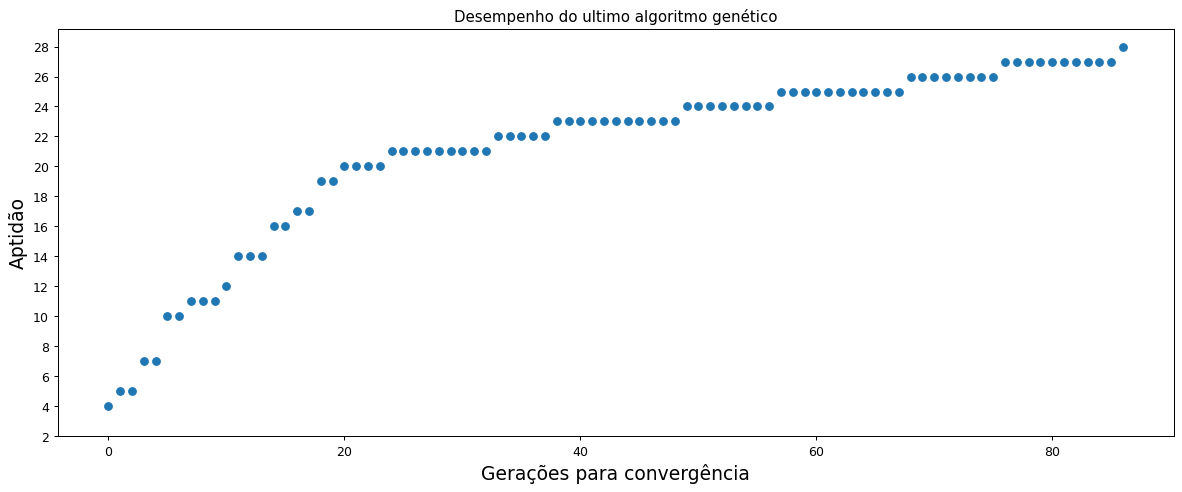

In [6]:
plt.figure(figsize=(16,6),dpi=90)
plt.scatter(range(len(bestPontuacaoList)),bestPontuacaoList)
plt.xlabel("Gerações para convergência",fontsize=15)
plt.ylabel("Aptidão",fontsize=15)
plt.title("Desempenho do ultimo algoritmo genético")
plt.yticks(range(2,30,2))
plt.show()

### Questão 1d
**Pergunta:** Faça experimentos com o parâmetro probabilidade de mutação. O que acontece com
o desempenho do algoritmo?

**R.:** 
- Mantendo-se os mesmos parametros da Questão 1c e variando a probabilidade de mutação entre os valores de 1% a 20%, incrementando de 2 a 2%, gerou-se o gráfico abaixo. 
- Com isso, é possível perceber que o algoritmo converge melhor para valores de mutação entre 2.5% a 5% e após isso, o desempenho do algoritmo fica muito ruim.

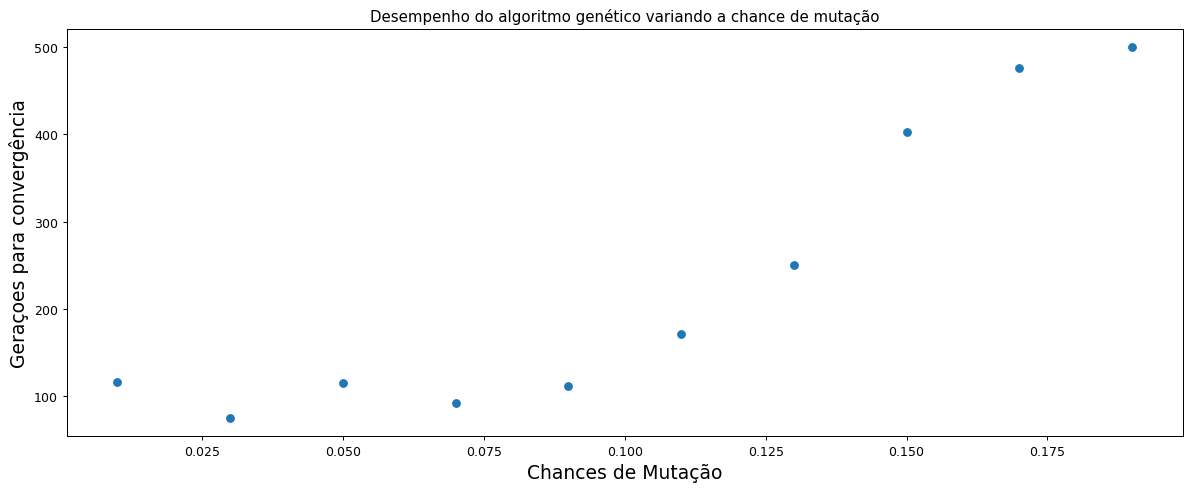

In [7]:
chancesMutacao = np.arange(0.01,0.2,0.02)
MediaPontuacaoPorMutacao = []


for chanceMutacao in chancesMutacao:
    ngens = []
    for i in range(5): # Realiza o algoritmo 5 vezes para calcular sua media
        algoritmo_weasel = AlgoritmoEvolutivo_Weasel(populacao=100)
        [ngen,bestPontuacao, bestFrase,bestPontuacaoList] = algoritmo_weasel.run(maxgen=500,
                                                                                chanceMutacao=chanceMutacao,
                                                                                chanceCrossOver=0.9,
                                                                                nElitismo=25)
        ngens.append(ngen)
    MediaPontuacaoPorMutacao.append(np.mean(ngens))
clear_output(wait=True) # Limpa o console
plt.figure(figsize=(16,6),dpi=90)

plt.scatter(chancesMutacao, MediaPontuacaoPorMutacao)
plt.ylabel("Geraçoes para convergência",fontsize=15)
plt.xlabel("Chances de Mutação",fontsize=15)
plt.title("Desempenho do algoritmo genético variando a chance de mutação")
plt.show()

### Questão 1e
**Pergunta:** Faça experimentos com o parâmetro probabilidade de cruzamento. O que acontece
com o desempenho do algoritmo?

**R.:** 
- Mantendo-se os mesmos parametros da Questão 1c e variando a probabilidade de cruzamento entre os valores de 50% a 100%, incrementando de 5 a 5%, gerou-se o gráfico abaixo. 

- Com isso, é possível perceber que o algoritmo converge melhor para valores de cruzamento entre 80% e 90% e após/antes disso, o desempenho do algoritmo fica muito ruim.

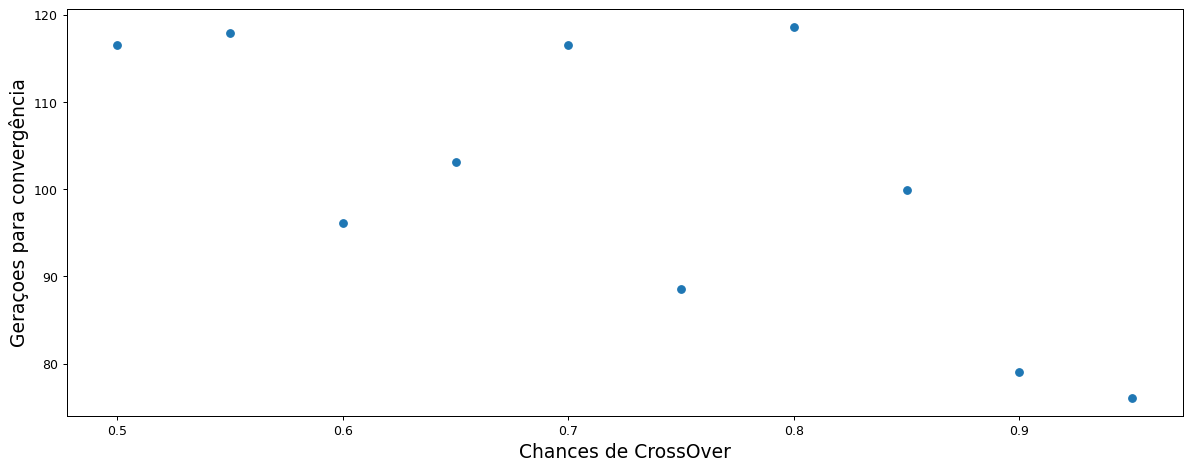

In [8]:
chancesCrossOver = np.arange(0.5,1,0.05)
MediaPontuacaoPorCrossOver = []


for chanceCrossOver in chancesCrossOver:
    ngens = []
    for i in range(10): # Realiza o algoritmo 10 vezes para calcular sua media
        algoritmo_weasel = AlgoritmoEvolutivo_Weasel(populacao=100)
        [ngen,bestPontuacao, bestFrase,bestPontuacaoList] = algoritmo_weasel.run(maxgen=500,
                                                                                chanceMutacao=0.05,
                                                                                chanceCrossOver=chanceCrossOver,
                                                                                nElitismo=25)
        ngens.append(ngen)
    MediaPontuacaoPorCrossOver.append(np.mean(ngens))
clear_output(wait=True) # Limpa o console
plt.figure(figsize=(16,6),dpi=90)

plt.scatter(chancesCrossOver, MediaPontuacaoPorCrossOver)
plt.ylabel("Geraçoes para convergência",fontsize=15)
plt.xlabel("Chances de CrossOver",fontsize=15)
plt.show()

## Questão 2 - Problema da Mochila 0/1

In [9]:
# Valores do enunciado
pesos_Objetos =   [10, 18, 12, 14, 13, 11, 8, 6]
valores_Objetos = [ 5,  8,  7,  6,  9,  5, 4, 3]
capacidade_Mochila = 35
rho = max([valor/peso for valor,peso in zip(valores_Objetos,pesos_Objetos)])

In [10]:
class Individuo_Mochila(): # Representa uma possibilidade de pesos*valores na mochila
    def __init__(self,genotipo=None):
        if genotipo == None:
            self.genotipo = [random.randint(0, 1) for i in range(len(pesos_Objetos))]
        else:
            self.genotipo = genotipo
        self.score = self.GetAptidao()
      
    def GetAptidao(self):
        pesoTotal = np.dot(self.genotipo,pesos_Objetos)
        beneficioTotal = np.dot(self.genotipo,valores_Objetos)
        
        penalidade = 0
        if pesoTotal > capacidade_Mochila:
            penalidade = rho*(pesoTotal-capacidade_Mochila)
            
        aptidao = beneficioTotal - penalidade
        return aptidao
        
    def Mutate(self,mutationChance):
        genotipoPosMutacao = [] #Genotipo apos a mutacao
        for objeto_inserido in self.genotipo:
            randomico = random.random() # Pega um numero aleatorio entre 0 e 1 (float)
            if random.random() <= mutationChance: # Caso ocorra a mutacao  
                genotipoPosMutacao.append(abs(objeto_inserido - 1)) # BitFlip
            else:
                genotipoPosMutacao.append(objeto_inserido)
                
        self.genotipo = genotipoPosMutacao     
        self.GetAptidao() # Atualiza aptidao após mutação

In [11]:
class AlgoritmoGenetico_Mochila01():
    def __init__(self,populacao:int = 20):
        self.population = []
        self.bestPontuacaoList = []
        self.meanPontuacaoList = [] 
        for i in range (populacao):
            self.population.append(Individuo_Mochila())
            
    def ParentSelector(self): # Roulette-wheel selection
        probabilidades = [],[]# lista de 2 dimensoes contendo em [0] -> as probabilidades e [1] - > probab acumulada
        aptidaoTotal = sum([individuo.score for individuo in self.population])
        probabAcumulada = 0
        for individuo in self.population:
            probabilidades[0].append(individuo.score/aptidaoTotal)
            probabAcumulada += individuo.score/aptidaoTotal
            probabilidades[1].append(probabAcumulada)         
        parents = []
        for i in range(2): # Seleciona 2 pais
            roleta = random.random() # numero de 0 a 1
            for j,probabAcumulada in enumerate(probabilidades[1]):
                if(roleta < probabAcumulada): # se o numero da roleta for menor que o da prob, parar
                    parents.append(self.population[j])                       
                    break
        return parents   

            
    def CrossOver(self,parents,crossOverChance = 0.7): # Single Point Crossover
        if random.random() < crossOverChance:
            pai1Genotipo = parents[0].genotipo
            pai2Genotipo = parents[1].genotipo 
            pos = random.randrange(len(pai1Genotipo)) # single point crossover -> Pega a posicao para o corte
            filho1Genotipo = pai1Genotipo[:pos] + pai2Genotipo[pos:]
            filho2Genotipo = pai2Genotipo[:pos] + pai1Genotipo[pos:]  
            filho1 = Individuo_Mochila(filho1Genotipo)
            filho2 = Individuo_Mochila(filho2Genotipo)
        else: # Caso n ocorra o crossover, os filhos tem as mesmas caracteristicas dos pais
            filho1 = parents[0]
            filho2 = parents[1]
        return [filho1,filho2]
    
    
    def run(self,maxgen=2000,chanceCrossOver=0.8,chanceMutacao=0.03,geracoesIguais=5):
        ngen=0
        while ngen < maxgen: 
            ngen +=1
            
            # Algoritmo evolutivo
            novaPopulacao = []
            for i in range(int(len(self.population)/2)): # 
                parents = self.ParentSelector()
                filhos = self.CrossOver(parents,crossOverChance=chanceCrossOver)
                for filho in filhos:
                    filho.Mutate(mutationChance=chanceMutacao)
                    novaPopulacao.append(filho) # Adiciona o filho  (depois de muta-lo) à nova populacao   
            self.population = novaPopulacao
            bestPontuacao = max([individuo.score for individuo in self.population])
            
            # Avaliacao do Algoritmo
            self.bestPontuacaoList.append(bestPontuacao)
            clear_output(wait=True) # Limpa o console, para sobrescrever o print abaixo
            print("Geração Atual:{}/{}         MelhorPontuação:{}".format(ngen+1,maxgen,bestPontuacao))
            melhorGenotipoIndex = [individuo.score for individuo in self.population].index(bestPontuacao)
            print("Melhor Genotipo[{}]: {}".format(melhorGenotipoIndex,self.population[melhorGenotipoIndex].genotipo))
            #Condicao de Parada
            # Checa se as ultimas n geracoes sao iguais e para o algoritmo caso seja -> CONVERGIU
            if (len(self.bestPontuacaoList) > geracoesIguais) and (self.bestPontuacaoList[-geracoesIguais:].count(self.bestPontuacaoList[-1]) == geracoesIguais):
                print("Todas {} geracoes passadas tem o mesmo valor".format(geracoesIguais))
                break
        return [ngen,self.bestPontuacaoList]

In [19]:
ngens = []
melhoresPontuacoes = []
for i in range(5):
    algoritmo_Mochila01 = AlgoritmoGenetico_Mochila01(200)
    [ngen, bestPontuacaoList_Mochila01] = algoritmo_Mochila01.run(maxgen=300,chanceCrossOver=0.7,chanceMutacao=0.05,geracoesIguais=25)
    ngens.append(ngen)
    melhoresPontuacoes.append(bestPontuacaoList)

print("Média Geraçoes:{}".format(np.mean(ngens)))

Geração Atual:75/300         MelhorPontuação:21
Melhor Genotipo[0]: [1, 0, 1, 0, 1, 0, 0, 0]
Todas 25 geracoes passadas tem o mesmo valor
Média Geraçoes:79.0


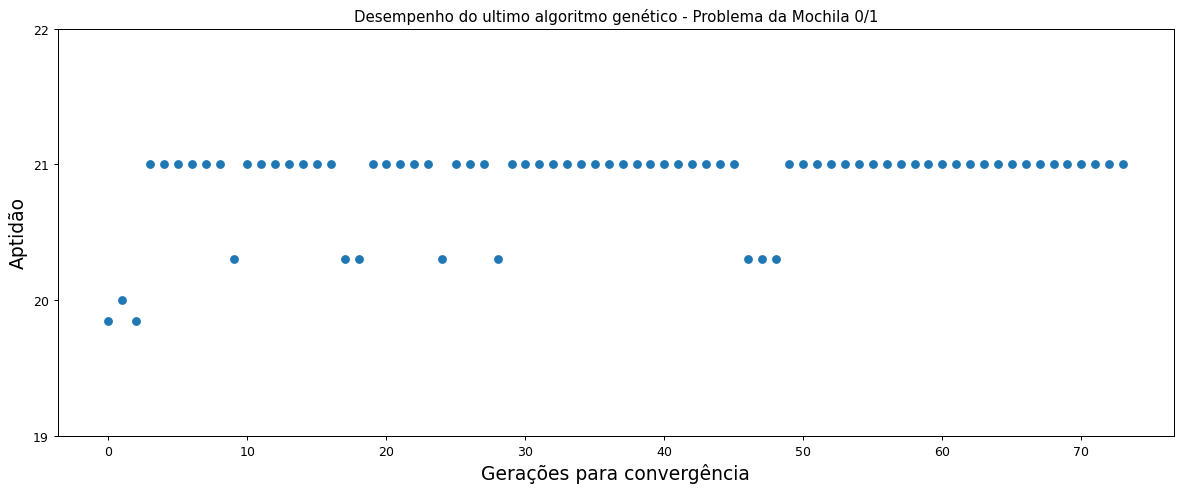

In [20]:
plt.figure(figsize=(16,6),dpi=90)
plt.scatter(range(len(bestPontuacaoList_Mochila01)),bestPontuacaoList_Mochila01)
plt.xlabel("Gerações para convergência",fontsize=15)
plt.ylabel("Aptidão",fontsize=15)
plt.title("Desempenho do ultimo algoritmo genético - Problema da Mochila 0/1")
plt.yticks(range(19,23,1))
plt.show()

### Observações
- A condição de término foi tirada do livro "Introduction to Evolutionary Computing" em que o algoritmo parava quando não houvesse melhorias na aptidao nas últimas 25 gerações


- Foi utilizado todos os métodos anunciados na questão e precisou-se de, em média, **59.8** gerações para o algoritmo chegar no resultado desejado.


- Observou-se que logo no começo do algoritmo, algumas populações ja obtiveram a pontuação ótima, de 21 pontos, dada pelo Genótipo [1,0,1,0,1,0,0,0]. Isto se deve à possibilidade significativa de gerar esse genótipo aleatoriamente, de 1 em 2^8, ou seja 0.39% de chance. 
    - A cada individuo, há uma possibilidade de 99.61% dele não possuir o genótipo ideal, com isso, em uma população de 200, existe uma chance de 45.77% de nenhum individuo possuir esse genótipo.
        - Portanto, em uma população de 200, há uma possibilidade de 54.23% do genótipo ideal ser gerado na primeira geração, como pode ser observado no código abaixo:

In [14]:
bestGenotipos = []
for i in range(10001):
    algoritmo_Mochila01_2 = AlgoritmoGenetico_Mochila01(200)
    melhorGenotipo = max([individuo.score for individuo in algoritmo_Mochila01_2.population])
    bestGenotipos.append(melhorGenotipo)
    if i % 1000 == 0: # Se for divisivel por 1000, para nao imprimir muitas vezes
        clear_output(wait=True) # Limpa o console, para sobrescrever o print abaixo 
        print("i Atual: {}".format(i))
        print("Média Atual: {}".format(bestGenotipos.count(21)/len(bestGenotipos)*100))

i Atual: 10000
Média Atual: 54.334566543345666


- Foi observado também que o algoritmo não convergia totalmente, isso se deve ao mecanismo geracional e ao operador de seleção proporcional ao fitness + Roleta. 
    - Como os descendentes foram gerados aleatoriamente a partir de pais com pesos diferentes, existia a possibilidade (ainda que pequena) de uma população inteira ser gerada e mutada e possuir uma aptidão pior que a da geração passada. 
    - Isso ocorre devido a perda da pressão na seleção, que é quando os valores de fitness são muito proximos. Quando isso acontece, a seleção tende a ter um caráter um pouco aleatório a partir de uma distribuição uniforme.
    - Uma possível solução para esse problema seria a utilização da seleção baseada em Ranking.